In [42]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('../../figure_style.mplstyle')

import sys
sys.path.insert(0, '../src')

import logging
logging.basicConfig(level=logging.INFO)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Modeling Burgers' as a 1D problem $u(x, 0) \rightarrow u(x, 1)$

Burgers' equation is a paradigmatic model of convection-diffusion phenomena. It describes the evolution of a 1-D $u(x, t)$ as

$$ \partial_t u + \frac{1}{2} \partial_x u^2 = \nu \partial_x^2 u $$

In `burgers_data_R10.mat`, the equation is solved for $\nu = 0.1$ from random initial conditions $u(x, 0) = u_0(x)$ and a periodic boundary. Here, a 1-D Fourier neural operator predicts the mapping $u_0 \rightarrow u(x, 1)$

INFO:data_processing:Loading dataset from ../data/Burgers/burgers_data_R10.mat


INFO:data_processing:Input shape: (2048, 8192)	Output shape: (2048, 8192)
INFO:data_processing:Adding positional encoding
INFO:data_processing:Creating TensorDataset with input shape: torch.Size([2048, 2, 8192]), output shape: torch.Size([2048, 1, 8192])
INFO:data_processing:Training dataset length: 1639
INFO:data_processing:Validation dataset length: 409


[Text(0.5, 0, '$x$'),
 Text(0.5, 1.0, 'Positional Embedding'),
 (0.0, 1.0),
 (0.0, 1.0)]

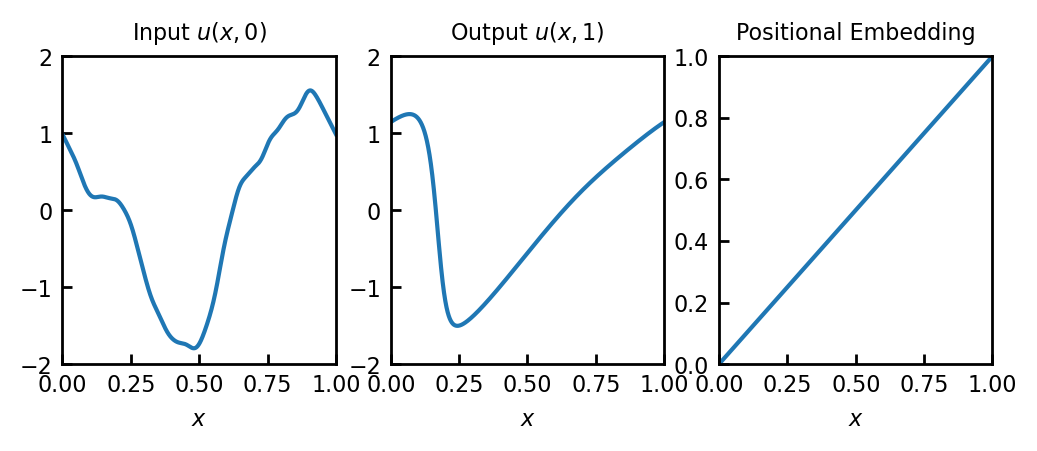

In [109]:
from data_processing import load_burgers_1d_data
train, val = load_burgers_1d_data()

fig, ax = plt.subplots(1, 3, figsize=(6, 2), sharex=True, sharey=False)

x, y = train[100]

ax[0].plot(x[1], x[0])
ax[1].plot(x[1], y[0])
ax[2].plot(x[1], x[1])

ax[0].set(xlabel='$x$', title='Input $u(x, 0)$', ylim=[-2, 2])
ax[1].set(xlabel='$x$', title='Output $u(x, 1)$', ylim=[-2, 2])
ax[2].set(xlabel='$x$', title='Positional Embedding', xlim=[0, 1], ylim=[0, 1])

INFO:train_FNO:Building a FNO1d
INFO:train_FNO:Loading model weights from ../models/Burgers_1d//model_weight.ckpt
INFO:train_FNO:Model reached loss=0.00089 at epoch 8
INFO:train_FNO:Loading dataset using data_processing.load_burgers_1d_data
INFO:data_processing:Loading dataset from ../data/Burgers/burgers_data_R10.mat
INFO:data_processing:Input shape: (2048, 8192)	Output shape: (2048, 8192)
INFO:data_processing:Adding positional encoding
INFO:data_processing:Creating TensorDataset with input shape: torch.Size([2048, 2, 8192]), output shape: torch.Size([2048, 1, 8192])
INFO:data_processing:Training dataset length: 1639
INFO:data_processing:Validation dataset length: 409


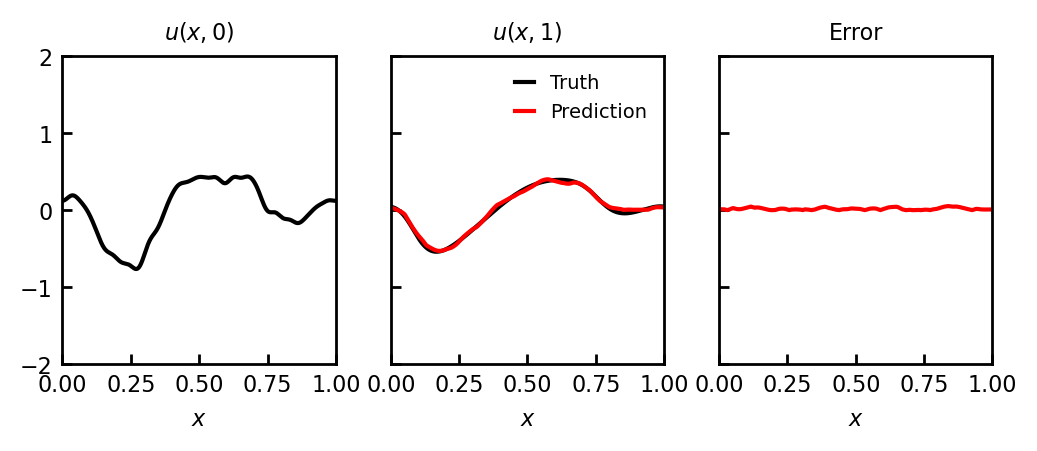

In [115]:
from train_FNO import get_model, get_dataset
import yaml
from pprint import pprint

import torch
if torch.cuda.is_available():
    device = torch.device('cuda:0')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

with open('../models/Burgers_1d/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

model = get_model(config['model'])
train, val = get_dataset(config['dataset'])
model.eval()
model.to(device);

with torch.no_grad():
    x, y0 = val[10]
    x = x.to(device)

    y1 = model(x[None, :model.in_channels])[0]

    x = x.cpu().numpy()
    y1 = y1.cpu().numpy()
    y0 = y0.cpu().numpy()

fig, ax = plt.subplots(1, 3, figsize=(6, 2), sharex=True, sharey=True)

ax[0].plot(x[1], x[0], color='black')
ax[1].plot(x[1], y0[0], color='black', label='Truth')
ax[1].plot(x[1], y1[0], color='red', label='Prediction')
ax[2].plot(x[1], np.abs(y1[0] - y0[0]), color='red')

ax[0].set(xlabel='$x$', title='$u(x, 0)$', xlim=[0, 1], ylim=[-2, 2])
ax[1].set(xlabel='$x$', title='$u(x, 1)$')
ax[2].set(xlabel='$x$', title='Error')

ax[1].legend()


# Modeling spatio-temporal evolution of Burgers' equation

In `burgers_v100_t100_r1024_N2048.mat`, Burgers' equation is solved for $\nu = 0.01$ at a range of time points beteen 0 and 1. Here, a 2D Fourier neural operator forecasts the dynamics for all time rather than just at the final condition.

INFO:data_processing:Loading dataset from ../data/Burgers/burgers_v100_t100_r1024_N2048.mat
INFO:data_processing:Loaded Burgers dataset with nu = 0.01
INFO:data_processing:Input shape: (2048, 1024)	Output shape: (2048, 101, 1024)
INFO:data_processing:Adding positional and temporal encoding
INFO:data_processing:Creating TensorDataset with input shape: torch.Size([2048, 3, 101, 1024]), output shape: torch.Size([2048, 1, 101, 1024])
INFO:data_processing:Training dataset length: 1639
INFO:data_processing:Validation dataset length: 409


torch.Size([3, 101, 1024]) torch.Size([1, 101, 1024])


[Text(0.5, 0, '$x$'), Text(0.5, 1.0, 'Temporal Embedding')]

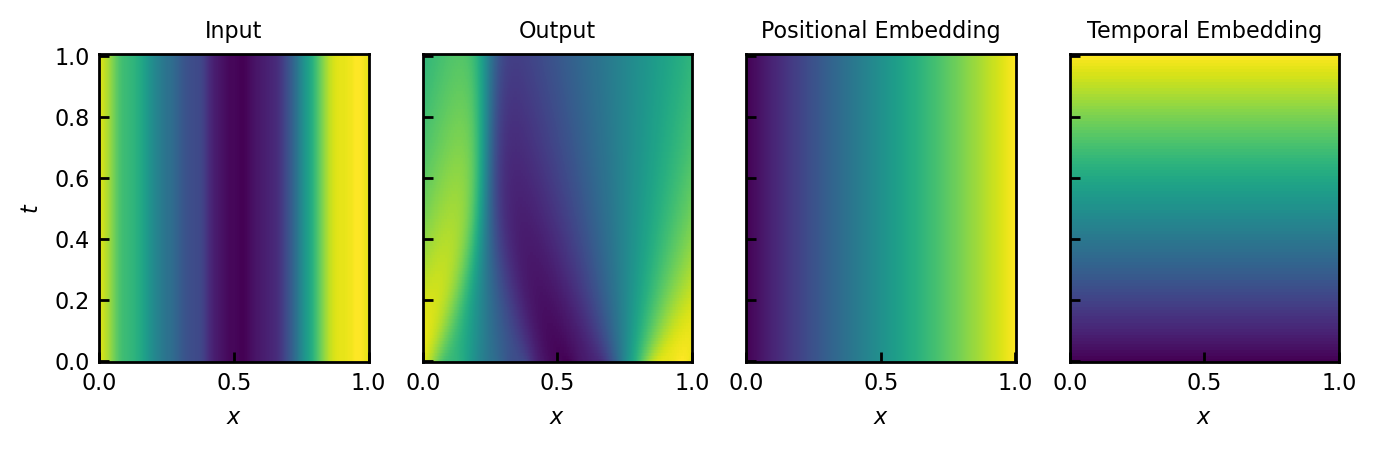

In [116]:
from data_processing import load_burgers_2d_data
train, val = load_burgers_2d_data(path='../data/Burgers/burgers_v100_t100_r1024_N2048.mat')

fig, ax = plt.subplots(1, 4, figsize=(8, 2), sharex=True, sharey=True)

x, y = train[100]
print(x.shape, y.shape)

ax[0].pcolormesh(x[1], x[2], x[0])
ax[1].pcolormesh(x[1], x[2], y[0])
ax[2].pcolormesh(x[1], x[2], x[1])
ax[3].pcolormesh(x[1], x[2], x[2])

ax[0].set(xlabel='$x$', ylabel='$t$', title='Input')
ax[1].set(xlabel='$x$', title='Output')
ax[2].set(xlabel='$x$', title='Positional Embedding')
ax[3].set(xlabel='$x$', title='Temporal Embedding')

INFO:train_FNO:Building a FNO2d


INFO:train_FNO:Loading model weights from ../models/Burgers_2d//model_weight.ckpt
INFO:train_FNO:Model reached loss=7.21e-05 at epoch 8
INFO:train_FNO:Loading dataset using data_processing.load_burgers_2d_data
INFO:data_processing:Loading dataset from ../data/Burgers/burgers_v100_t100_r1024_N2048.mat
INFO:data_processing:Loaded Burgers dataset with nu = 0.01
INFO:data_processing:Input shape: (2048, 1024)	Output shape: (2048, 101, 1024)
INFO:data_processing:Adding positional and temporal encoding
INFO:data_processing:Creating TensorDataset with input shape: torch.Size([2048, 3, 101, 1024]), output shape: torch.Size([2048, 1, 101, 1024])
INFO:data_processing:Training dataset length: 1639
INFO:data_processing:Validation dataset length: 409


[Text(0.5, 0, '$x$'), Text(0.5, 1.0, 'Error')]

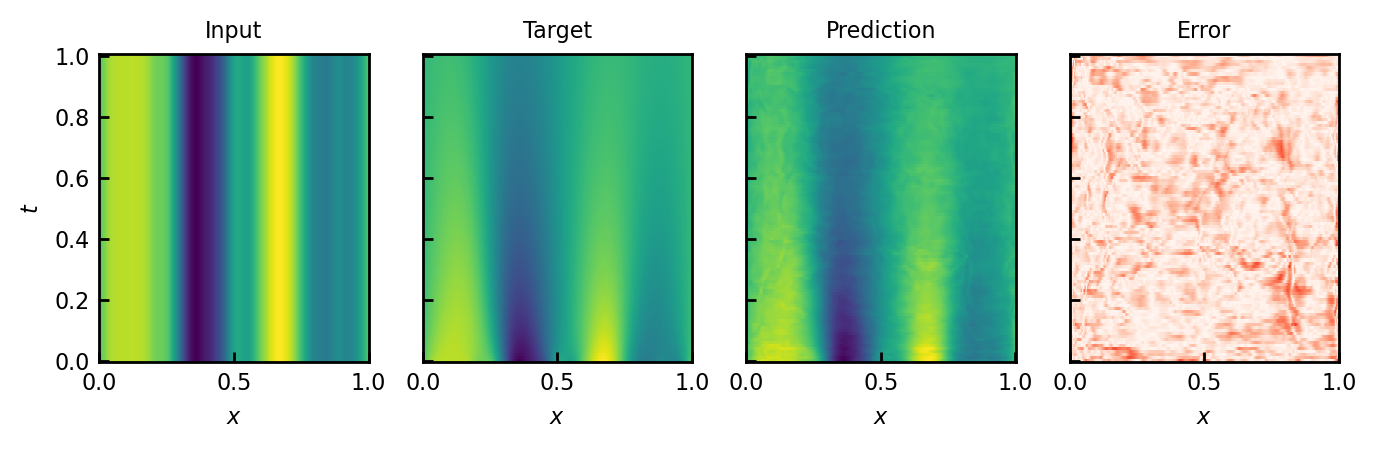

In [117]:
from train_FNO import get_model, get_dataset
import yaml
from pprint import pprint

import torch
if torch.cuda.is_available():
    device = torch.device('cuda:0')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

with open('../models/Burgers_2d/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

model = get_model(config['model'])
train, val = get_dataset(config['dataset'])
model.eval()
model.to(device);

with torch.no_grad():
    x, y0 = val[10]
    x = x.to(device)

    y1 = model(x[None, :model.in_channels])[0]

    x = x.cpu().numpy()
    y1 = y1.cpu().numpy()
    y0 = y0.cpu().numpy()

fig, ax = plt.subplots(1, 4, figsize=(8, 2), sharex=True, sharey=True)


ax[0].pcolormesh(x[1], x[2], x[0])
ax[1].pcolormesh(x[1], x[2], y0[0])
ax[2].pcolormesh(x[1], x[2], y1[0])
ax[3].pcolormesh(x[1], x[2], np.abs(y1[0] - y0[0]), cmap='Reds', vmin=0)

ax[0].set(xlabel='$x$', ylabel='$t$', title='Input')
ax[1].set(xlabel='$x$', title='Target')
ax[2].set(xlabel='$x$', title='Prediction')
ax[3].set(xlabel='$x$', title='Error')

INFO:train_FNO:Building a FNO1p1d
INFO:train_FNO:Loading model weights from ../models/Burgers_1p1d//model_weight.ckpt
INFO:train_FNO:Model reached loss=0.000171 at epoch 9
INFO:train_FNO:Loading dataset using data_processing.load_burgers_2d_data
INFO:data_processing:Loading dataset from ../data/Burgers/burgers_v100_t100_r1024_N2048.mat
/Users/jcolen/miniconda3/envs/fno/lib/python3.12/site-packages/scipy/io/matlab/_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Considerscipy.io.matlab._mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)
INFO:data_processing:Loaded Burgers dataset with nu = 0.01
INFO:data_processing:Input shape: (2048, 1024)	Output shape: (2048, 101, 1024)
INFO:data_processing:Adding positional and temporal encoding
INFO:data_processing:Creating TensorDataset with input shape: torch.Size([2048, 3, 101, 1024]), output shape: torch.Size([2048, 1, 101, 1024])
INF

[Text(0.5, 0, '$x$'), Text(0.5, 1.0, 'Error')]

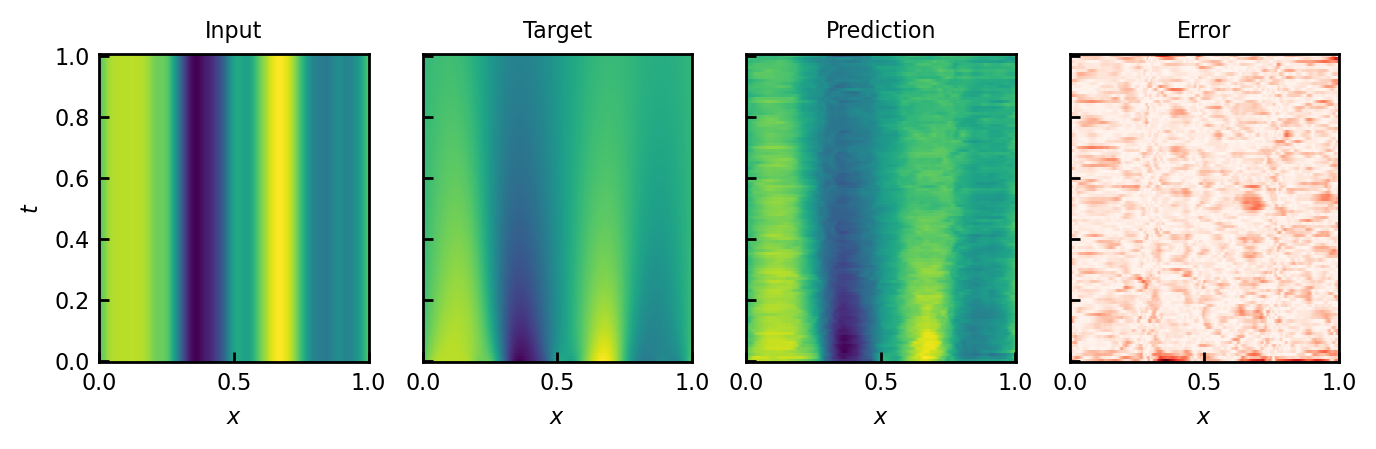

In [114]:
from train_FNO import get_model, get_dataset
import yaml
from pprint import pprint

import torch
if torch.cuda.is_available():
    device = torch.device('cuda:0')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

with open('../models/Burgers_1p1d/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

model = get_model(config['model'])
train, val = get_dataset(config['dataset'])
model.eval()
model.to(device);

with torch.no_grad():
    x, y0 = val[10]
    x = x.to(device)

    y1 = model(x[None, :model.in_channels])[0]

    x = x.cpu().numpy()
    y1 = y1.cpu().numpy()
    y0 = y0.cpu().numpy()

fig, ax = plt.subplots(1, 4, figsize=(8, 2), sharex=True, sharey=True)


ax[0].pcolormesh(x[1], x[2], x[0])
ax[1].pcolormesh(x[1], x[2], y0[0])
ax[2].pcolormesh(x[1], x[2], y1[0])
ax[3].pcolormesh(x[1], x[2], np.abs(y1[0] - y0[0]), cmap='Reds', vmin=0)

ax[0].set(xlabel='$x$', ylabel='$t$', title='Input')
ax[1].set(xlabel='$x$', title='Target')
ax[2].set(xlabel='$x$', title='Prediction')
ax[3].set(xlabel='$x$', title='Error')